In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 99)

/home/qile/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qile/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qile/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qile/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Make some helper functions

In [2]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df):
    print(f'Original size of data: {return_size(df)} gb.')
    for c in df:
        if df[c].dtype == 'object':
            df[c] = df[c].astype('category')
    print(f'New size of data: {return_size(df)} gb.')
    return df


# Customer OHE which finds Object columns and one-hot them
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)

    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Function to provide feature summary
def feature_summary(df_fa):
    print('DataFrame shape')
    print('rows:',df_fa.shape[0])
    print('cols:',df_fa.shape[1])
    col_list=['Null','Unique_Count','Data_type','Max/Min','Mean','Std','Skewness','Sample_values']
    df=pd.DataFrame(index=df_fa.columns,columns=col_list)
    df['Null']=list([len(df_fa[col][df_fa[col].isnull()]) for i,col in enumerate(df_fa.columns)])
    #df['%_Null']=list([len(df_fa[col][df_fa[col].isnull()])/df_fa.shape[0]*100 for i,col in enumerate(df_fa.columns)])
    df['Unique_Count']=list([len(df_fa[col].unique()) for i,col in enumerate(df_fa.columns)])
    df['Data_type']=list([df_fa[col].dtype for i,col in enumerate(df_fa.columns)])
    for i,col in enumerate(df_fa.columns):
        if 'float' in str(df_fa[col].dtype) or 'int' in str(df_fa[col].dtype):
            df.at[col,'Max/Min']=str(round(df_fa[col].max(),2))+'/'+str(round(df_fa[col].min(),2))
            df.at[col,'Mean']=df_fa[col].mean()
            df.at[col,'Std']=df_fa[col].std()
            df.at[col,'Skewness']=df_fa[col].skew()
        df.at[col,'Sample_values']=list(df_fa[col].unique())
           
    return(df.fillna('-'))

# Function to count uniques
def cnt_unique(df):
    return(len(df.unique()))

## Do the data preperation per table. For each table, create a function

In [3]:
# Data prep for installment table
def prep_ins ():
    
    # Only take the fist/last K installments 
    # to give more weights to recent/early payments
    k = 12
    
    
    ins = pd.read_csv('data/installments_payments.csv')
    
    
    ins = ins.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER']).agg({'NUM_INSTALMENT_VERSION':'max',
                                                            'SK_ID_CURR':'max',
                                                            'DAYS_INSTALMENT':'max',
                                                             'DAYS_ENTRY_PAYMENT':'min',
                                                             'AMT_INSTALMENT':'sum',
                                                             'AMT_PAYMENT':'max',
                                                             }) \
    .reset_index()

    ins['Desc_rank'] = ins.groupby('SK_ID_PREV')["NUM_INSTALMENT_NUMBER"].rank("dense", ascending=False)
    
    # New features
    ins['days_late'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['days_early'] = np.where(ins['days_late']>=0,ins['days_late'],0)    
    ins['days_late'] = np.where(ins['days_late']<0,ins['days_late']*-1,0)
    ins['days_late_14_flag'] = np.where(ins['days_late'] > 14,1,0)
    ins['amt_short'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['amt_extra'] = np.where(ins['amt_short'] > 0, ins['amt_short'],0)
    ins['amt_short'] = np.where(ins['amt_short'] <= 0, ins['amt_short']*-1,0)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    
    g = ins.groupby(['SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'].agg(['sum','max']) \
        .reset_index().rename(index=str, columns={'sum':'Installment_SUM','max':'Installment_MAX'})
        
    ins = ins.merge(g, on = ['SK_ID_PREV'], how = 'left')

    
    ins_first_k = ins.loc[ins.NUM_INSTALMENT_NUMBER <= k]
    #ins_last_k = ins.loc[ins.Desc_rank<=k]
    
    
    aggregation_recipe = {
        'SK_ID_CURR':['max'],
        'NUM_INSTALMENT_VERSION' : 'nunique',
        #'NUM_INSTALMENT_NUMBER' : 'max',
       #  'DAYS_INSTALMENT': ['max','min'],
    #     'DAYS_ENTRY_PAYMENT': ['max'],
        'AMT_INSTALMENT':['max','min','median'],
        'AMT_PAYMENT':['max','min','median'],
        'days_late':['max', 'mean', 'sum','std','min'],
        'days_early':['max', 'mean', 'sum','std','min'],
        'amt_short':['max','min','sum','std','mean'],
        'amt_extra':['max','min','sum','std','mean'],
        'Installment_SUM' : 'max',
        'Installment_MAX' :  'max',
        'PAYMENT_PERC':['max', 'mean', 'sum', 'std'],
        'days_late_14_flag':['sum','mean']
                            }


    ins_first_k = ins_first_k.groupby('SK_ID_PREV').agg(aggregation_recipe)
    ins_first_k.columns = pd.Index([e[0] + "_" + e[1].upper() for e in ins_first_k.columns.tolist()])
    ins = ins.groupby('SK_ID_PREV').agg(aggregation_recipe)
    ins.columns = pd.Index([e[0] + "_" + e[1].upper() for e in ins.columns.tolist()])
    ins_first_last_k = pd.merge(ins,ins_first_k, on='SK_ID_PREV',how='left')
    
    # Calculate the difference
    #diff_cols = [f for f in ins_first_k.columns if f not in ['SK_ID_CURR_MAX','SK_ID_CURR_MAX']]
#     diff_cols = [f for f in ins_first_k.columns if ('days_late' in f) | ('days_early' in f)
#                  | ('NUM_INSTALMENT_VERSION' in f)| ('PAYMENT_PERC_MEAN' in f)]

#     for i in diff_cols:
#         diff_name = '{}_diff'.format(i)
#         x_name = '{}_x'.format(i)
#         y_name = '{}_y'.format(i)

#         ins_first_last_k[diff_name] = ins_first_last_k[x_name] - ins_first_last_k[y_name] 
    
    del ins
    gc.collect()

    ins_first_last_k.drop('SK_ID_CURR_MAX_y', axis=1,inplace=True)
    ins_first_last_k.rename(columns={'SK_ID_CURR_MAX_x':'SK_ID_CURR'}, inplace=True)
    ins_first_last_k = ins_first_last_k.reset_index()
    ins_first_last_k.drop('SK_ID_PREV', axis=1, inplace=True)
    ins_first_last_k = ins_first_last_k.groupby('SK_ID_CURR').mean().reset_index()
    
    return ins_first_last_k

In [4]:
def prep_pos ():

    pos = convert_types(pd.read_csv('data/POS_CASH_balance.csv'))
    
    pos['Desc_rank'] = pos.groupby('SK_ID_PREV')["MONTHS_BALANCE"].rank("dense", ascending=False)

    # Assign more weights to recent months
    def month_index (month):
        if month <= 6:
            index = 1
        elif 6 < month <= 12:
            index = 0.9   
        elif 12 < month <= 18:
            index = 0.8
        elif 18 < month <= 24:
            index = 0.7
        else:
            index = 0
        return index

    pos['month_index'] = pos.Desc_rank.map(lambda x: month_index(x))
    pos = pd.get_dummies(pos, columns= ['NAME_CONTRACT_STATUS'],dummy_na=True)
    pos['zero_count'] = np.where(pos['CNT_INSTALMENT_FUTURE']==0,1,0)
    pos = pos.sort_values(['SK_ID_PREV','MONTHS_BALANCE'])
    pos['day_diff'] = (pos.groupby(['SK_ID_PREV']).CNT_INSTALMENT_FUTURE.shift(1) - pos.CNT_INSTALMENT_FUTURE)
    pos['SK_DPD_weight'] = pos.SK_DPD * pos.month_index
    pos['SK_DPD_DEF_weight'] = pos.SK_DPD_DEF * pos.month_index
    aggregation_recipepos_pos = {
        'SK_ID_CURR': ['max','count'],
        'MONTHS_BALANCE':['max','min'],
        'CNT_INSTALMENT' :['max','nunique'],
        'CNT_INSTALMENT_FUTURE' : 'min',
        'day_diff': ['max','mean','sum'],
        'SK_DPD': ['min', 'max', 'size', 'mean', 'std', 'sum'],
        'SK_DPD_DEF':['min', 'max', 'size', 'mean', 'std', 'sum'],
        'zero_count' : ['sum'],
        'SK_DPD_weight':['sum','mean', 'max'],
        'SK_DPD_DEF_weight':['sum','mean', 'max'],
        'month_index':['sum']
    }

    contract_status = [_f for _f in pos.columns if 'NAME_CONTRACT_STATUS_' in _f]
    for col in contract_status:
        aggregation_recipepos_pos[col] = 'mean'


    pos_agg = pos.groupby(['SK_ID_PREV']).agg(aggregation_recipepos_pos)
    pos_agg.columns = pd.Index(["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg = pos_agg.reset_index()
    pos_agg['POS_premature'] = np.where(pos_agg['POS_day_diff_MAX'] > 1,1,0)
    pos_agg['POS_extended'] = np.where(pos_agg['POS_zero_count_SUM'] > 1,1,0)
    pos_agg['POS_still_active'] = np.where(pos_agg['POS_NAME_CONTRACT_STATUS_Completed_MEAN'] > 1,1,0)
    pos_agg.rename(columns={'POS_SK_ID_CURR_COUNT':'POS_num_row','POS_SK_ID_CURR_MAX':'SK_ID_CURR'}, inplace=True)
   
    #     g = pos_agg.groupby('SK_ID_CURR')['POS_month_index_SUM'].sum().reset_index()
#     g.rename(index=str, columns={'POS_month_index_SUM':'Curr_total_weight'}, inplace=True)
    
    g = pos_agg.groupby('SK_ID_CURR')['POS_SK_DPD_SUM'].sum().reset_index()
    g.rename(index=str, columns={'POS_SK_DPD_SUM':'Curr_total_weight'}, inplace=True)
   
    pos_agg = pos_agg.merge(g, how='left', on='SK_ID_CURR')
    pos_agg['weight'] = pos_agg.POS_month_index_SUM/pos_agg.Curr_total_weight


    reweight_cols = [e for e in pos_agg.columns.tolist() if ('SK_ID' not in e) & ('weight' not in e)]

    pos_agg[reweight_cols] = pos_agg[reweight_cols].multiply(pos_agg['weight'], axis="index")

    reweight_aggregation = {}

    for col in pos_agg.columns.tolist():
        if 'SK_ID_CURR'  not in col:
            reweight_aggregation[col]='sum'
        elif 'SK_ID_PREV'  in col:
            reweight_aggregation[col]='size'


    pos_agg_2nd = pos_agg.groupby('SK_ID_CURR').agg(reweight_aggregation).reset_index()


    
    
    return pos_agg_2nd


In [5]:
def prep_cc ():
    cc = pd.read_csv('data/credit_card_balance.csv')
    cc = pd.get_dummies(cc, columns= ['NAME_CONTRACT_STATUS'],dummy_na=True)
    def month_index (month):
        if month <= 6:
            index = 1
        elif 6 < month <= 12:
            index = 0.9   
        elif 12 < month <= 18:
            index = 0.8
        elif 18 < month <= 24:
            index = 0.7
        else:
            index = 0
        return index
    cc['month_index'] = cc.MONTHS_BALANCE.map(lambda x: month_index(x*-1))
    cc['card missing'] = cc.isnull().sum(axis = 1).values
    cc['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = cc['AMT_TOTAL_RECEIVABLE'] - cc['AMT_RECIVABLE']
    cc['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = cc['AMT_TOTAL_RECEIVABLE'] - cc['AMT_RECEIVABLE_PRINCIPAL']
    cc['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = cc['AMT_RECIVABLE'] - cc['AMT_RECEIVABLE_PRINCIPAL']

    cc['card AMT_BALANCE - AMT_RECIVABLE'] = cc['AMT_BALANCE'] - cc['AMT_RECIVABLE']
    cc['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = cc['AMT_BALANCE'] - cc['AMT_RECEIVABLE_PRINCIPAL']
    cc['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = cc['AMT_BALANCE'] - cc['AMT_TOTAL_RECEIVABLE']

    cc['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = cc['AMT_DRAWINGS_CURRENT'] - cc['AMT_DRAWINGS_ATM_CURRENT']
    cc['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = cc['AMT_DRAWINGS_CURRENT'] - cc['AMT_DRAWINGS_OTHER_CURRENT']
    cc['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = cc['AMT_DRAWINGS_CURRENT'] - cc['AMT_DRAWINGS_POS_CURRENT']

    cc['SK_DPD_weight'] = cc.SK_DPD * cc.month_index
    cc['SK_DPD_DEF_weight'] = cc.SK_DPD_DEF * cc.month_index

    aggregations = {}
    for col in cc.columns.tolist():
        if 'SK_ID_CURR' in col:
            aggregations[col] = 'max'
        elif 'SK_ID_PREV' not in col:
            aggregations[col] = ['mean'] if 'NAME_CONTRACT_STATUS' in col else ['min', 'max', 'size', 'mean', 'std', 'sum']


    cc_agg = cc.groupby('SK_ID_PREV').agg(aggregations).reset_index()
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])


    cc_agg.rename(columns = {'CC_SK_ID_PREV_':'SK_ID_PREV','CC_SK_ID_CURR_MAX':'SK_ID_CURR'}, inplace=True)
#     g = cc_agg.groupby('SK_ID_CURR')['CC_month_index_SUM'].sum().reset_index()
#     g.rename(index=str, columns={'CC_month_index_SUM':'Curr_total_weight'}, inplace=True)
    
    g = cc_agg.groupby('SK_ID_CURR')['CC_SK_DPD_weight_SUM'].sum().reset_index()
    g.rename(index=str, columns={'CC_SK_DPD_weight_SUM':'Curr_total_weight'}, inplace=True)
    
    cc_agg = cc_agg.merge(g, how='left', on='SK_ID_CURR')
    cc_agg['weight'] = cc_agg.CC_month_index_SUM/cc_agg.Curr_total_weight


    reweight_cols = [e for e in cc_agg.columns.tolist() if ('SK_ID' not in e) & ('weight' not in e)]

    cc_agg[reweight_cols] = cc_agg[reweight_cols].multiply(cc_agg['weight'], axis="index")

    reweight_aggregation = {}

    for col in cc_agg.columns.tolist():
        if 'SK_ID_CURR'  not in col:
            reweight_aggregation[col]='sum'
        elif 'SK_ID_PREV'  in col:
            reweight_aggregation[col]='size'


    cc_agg_2nd = cc_agg.groupby('SK_ID_CURR').agg(reweight_aggregation).reset_index()

    return cc_agg_2nd
    


In [6]:
def prep_prev ():
    df_prev = pd.read_csv('data/previous_application.csv')
    df_prev, cat_cols = one_hot_encoder(df_prev, nan_as_category= True)
    df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
    df_prev['SELLERPLACE_AREA'].replace(-1, np.nan, inplace= True)
    df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
    df_prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df_prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    df_prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    df_prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    df_prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    df_prev['APP_CREDIT_PERC'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    
    aggregations = {}
    for col in df_prev.columns:
        aggregations[col] = ['mean'] if col in cat_cols else ['min', 'max', 'size', 'mean', 'std', 'sum']
    df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
    df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')
    del approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications
    refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')
    del refused_agg, df_prev
    gc.collect()    
    return df_prev_agg
    

In [7]:
def application_train_test(num_rows = None, nan_as_category = True):
    
    
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)

    df = df.append(test_df).reset_index()

        # Remove some rows with values not present in test set
    df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
    df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
    df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
    
    # Remove some empty features
    df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    

    # Replace some outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace = True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace = True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace = True)
    df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan

    
    df['app missing'] = df.isnull().sum(axis = 1).values
    df['New_annuity_credit_ratio'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['New_price_credit_ratio'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    df['New_income_credit_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['New_total_area_medi'] = df['APARTMENTS_MEDI'] + df['BASEMENTAREA_MEDI'] 
    + df['COMMONAREA_MEDI']+df['ELEVATORS_MEDI']+df['ENTRANCES_MEDI']
    + df.FLOORSMAX_MEDI + df.LANDAREA_MEDI + df.LIVINGAPARTMENTS_MEDI
    + df.LIVINGAREA_MEDI + df.NONLIVINGAPARTMENTS_MEDI + df.NONLIVINGAREA_MEDI + df.TOTALAREA_MODE
    df['New_child_fam_ratio'] = df['CNT_CHILDREN']/df['CNT_FAM_MEMBERS']
    df['New_employ_birth_ratio'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['New_publish_birth_ratio'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['New_phone_birth_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['New_registration_birth_ratio'] = df['DAYS_REGISTRATION'] / df['DAYS_BIRTH']
    df['New_total_docs_flag'] = df.FLAG_DOCUMENT_11 + df.FLAG_DOCUMENT_18 + df.FLAG_DOCUMENT_3
    + df.FLAG_DOCUMENT_6 + df.FLAG_DOCUMENT_5 + df.FLAG_DOCUMENT_8 + df.FLAG_DOCUMENT_9
    df['New_total_comm_flag'] =  df.FLAG_EMAIL + df.FLAG_EMP_PHONE + df.FLAG_PHONE + df.FLAG_WORK_PHONE
    df['New_live_work_sum'] = df.LIVE_CITY_NOT_WORK_CITY + df.LIVE_REGION_NOT_WORK_REGION
    df['New_reg_live_work_sum'] = df.REG_CITY_NOT_LIVE_CITY + df.REG_CITY_NOT_WORK_CITY
    df['New_total_live_work_sum'] = df.REG_REGION_NOT_LIVE_REGION + df.REG_REGION_NOT_WORK_REGION 
    + df.LIVE_CITY_NOT_WORK_CITY + df.LIVE_REGION_NOT_WORK_REGION    
    df['New_external_sources_prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    for function_name in ['sum', 'mean','std']:
        df['New_external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    df['group_age'] = pd.cut(df['DAYS_BIRTH'],10,labels=False)
    df['group_employ'] = pd.cut(df['DAYS_EMPLOYED'],10,labels=False)    
    df['group_income'] = pd.cut(df['AMT_INCOME_TOTAL'],30,labels=False)         
    df['group_CREDIT'] = pd.cut(df['AMT_CREDIT'],30,labels=False)         
    df['group_ANNUITY'] = pd.cut(df['AMT_ANNUITY'],30,labels=False)         
    df['group_PRICE'] = pd.cut(df['AMT_GOODS_PRICE'],30,labels=False)         
    
    
    drop_cols = ['APARTMENTS_AVG','APARTMENTS_MODE','BASEMENTAREA_AVG','BASEMENTAREA_MODE','COMMONAREA_AVG','COMMONAREA_MODE'
       ,'ELEVATORS_AVG','ELEVATORS_MODE','ENTRANCES_AVG','ENTRANCES_MODE','FLOORSMAX_AVG','FLOORSMAX_MODE'
       ,'FLOORSMIN_AVG','FLOORSMIN_MEDI','FLOORSMIN_MODE','LANDAREA_AVG','LANDAREA_MODE','LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MODE'
       ,'LIVINGAREA_AVG','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE'
       ,'NONLIVINGAREA_AVG','NONLIVINGAREA_MODE','YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MODE'
       ,'YEARS_BUILD_AVG','YEARS_BUILD_MODE']
      # , 'DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']  
    
    df.drop(drop_cols, axis =1 , inplace = True)
    
    
   
    df, cat_cols = one_hot_encoder(df, nan_as_category)


    gc.collect()
    
    return df


### Since EXT_SOURCE_1_2_3 are the top predictors but they also have a high percentage of missing values, run models to impute missing values by using the application data ONLY

A 2-fold LightGBM is used to prevent overfitting

In [8]:
def impute_ext (target = 'EXT_SOURCE_1', df=''):
    pd.options.mode.chained_assignment = None 
    df['external_'+ target[-1] +'_missing'] = np.where(df[target].notnull(),1,0)
    
    
    ext = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']+ext]
    feats = [f for f in feats if 'external_' not in f] 
    feats = feats + [f for f in ext if f != target]
    

    train_df = df.loc[df[target].notnull()]
    test_df = df.loc[df[target].isnull()]

    from lightgbm import LGBMRegressor
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    folds = KFold(n_splits= 2, shuffle=True, random_state=2427)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[target])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[target].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[target].iloc[valid_idx]

        clf = LGBMRegressor(
            objective='regression',
            metric= 'rmse',
            n_estimators=10000,
            learning_rate=0.05,
            #max_bin= 300,
            #max_depth= -1,
            num_leaves=20,
            subsample= 0.6,
            subsample_freq= 2,
            colsample_bytree= 0.8,
            )


        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'rmse', verbose = 10000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
        sub_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration_)/ folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #print('Fold %2d RMSE : %.6f' % (n_fold + 1, sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))
        test_df[target] = sub_preds

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

   # print('Full RMSE %.6f' % sqrt(mean_squared_error(train_df[target], oof_preds)))

    #test_df[target] = sub_preds
    df.loc[df[target].isnull(),target] = sub_preds
    return df, feature_importance_df
    
    
    
    
    
    
    
    


In [9]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_bureau_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv')
    bb = pd.read_csv('data/bureau_balance.csv')
    def month_index (month):
        if month <= 6:
            index = 1
        elif 6 < month <= 12:
            index = 0.9   
        elif 12 < month <= 18:
            index = 0.8
        elif 18 < month <= 24:
            index = 0.7
        else:
            index = 0
        return index

    bb['month_index'] = bb.MONTHS_BALANCE.map(lambda x: month_index(x*-1))

    bb = pd.get_dummies(bb, columns= ['STATUS'], dummy_na= False)
    bb = bb.groupby(['SK_ID_BUREAU','month_index']).mean().reset_index()
    status_list = ["STATUS_0", "STATUS_1", "STATUS_2", "STATUS_3", "STATUS_4", "STATUS_5", "STATUS_C", "STATUS_X"]
    bb[status_list] = bb[status_list].multiply(bb["month_index"], axis="index")
    bb = bb.groupby(['SK_ID_BUREAU']).sum().reset_index()
    #bb[status_list] = bb[status_list].div(bb["month_index"], axis="index")
    bureau = bureau.merge(bb, how='left', on='SK_ID_BUREAU')
    bureau['bureau missing'] = bureau.isnull().sum(axis = 1).values
    bureau['no_balance'] = np.where(bureau.month_index.isnull(),1,0)
    bureau = pd.get_dummies(bureau, columns= ['CREDIT_ACTIVE'], dummy_na= False)
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    bureau['CREDIT_CURRENCY'] = le.fit_transform(bureau['CREDIT_CURRENCY'])
    bureau['CREDIT_TYPE'] = le.fit_transform(bureau['CREDIT_TYPE'])

    bureau = bureau.sort_values(['SK_ID_CURR','DAYS_CREDIT'])
    bureau['day_diff_next_bureau'] = (bureau.groupby(['SK_ID_CURR']).DAYS_CREDIT.shift(1) - bureau.DAYS_CREDIT)
    bureau['extension'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['bureau_debt_credit'] = bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    aggregations = {}
    for col in bureau.columns:
        if col in ['CREDIT_CURRENCY','CREDIT_TYPE']:
            aggregations[col] = ['nunique']
        elif ('STATUS_' in col) | ('CREDIT_ACTIVE_' in col) | ('CREDIT_CURRENCY' in col):
            aggregations[col] = ['mean']
        else:
            aggregations[col] = ['min', 'max', 'size', 'mean', 'std', 'sum']


    bureau_both = bureau.groupby('SK_ID_CURR').agg(aggregations)
    bureau_both.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_both.columns.tolist()])
    drop = [e for e in bureau_both.columns.tolist() if 'BURO_SK_ID_' in e]
    bureau_both.drop(drop,axis = 1,inplace=True)



    # Bureau: Active credits
    active_agg = bureau[bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_both = bureau_both.join(active_agg, how = 'left')
    del active_agg
    gc.collect()

    # Bureau: Closed credits
    closed_agg = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_both = bureau_both.join(closed_agg, how = 'left')
    #del closed_agg, df_bureau
    gc.collect()

    return bureau_both


## Join the data together

In [11]:
application_df = application_train_test(nan_as_category = False)
application_df_imputed,feature_importance_ext_1 = impute_ext(target = 'EXT_SOURCE_1', df = application_df)
application_df_imputed,feature_importance_ext_2 = impute_ext(target = 'EXT_SOURCE_2', df = application_df_imputed)
application_df_imputed,feature_importance_ext_3 = impute_ext(target = 'EXT_SOURCE_3', df = application_df_imputed)
application_df_imputed['New_external_sources_prod_imputed'] = application_df_imputed['EXT_SOURCE_1'] * application_df_imputed['EXT_SOURCE_2'] * application_df_imputed['EXT_SOURCE_3']

new_ext_col = ['SK_ID_CURR','external_1_missing','external_2_missing','external_3_missing','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
'New_external_sources_prod','New_external_sources_sum','New_external_sources_mean','New_external_sources_std']

for function_name in ['sum', 'mean','std']:
    application_df_imputed['New_external_sources_{}_imputed'.format(function_name)] = eval('np.{}'.format(function_name))(
    application_df_imputed[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    
# old_ext_col = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','New_external_sources_prod',
# 'New_external_sources_sum','New_external_sources_mean','New_external_sources_std']

# old_ext_col = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','New_external_sources_prod',
# 'New_external_sources_sum','New_external_sources_mean','New_external_sources_std']

new_ext_col = ['SK_ID_CURR','external_1_missing','external_2_missing','external_3_missing','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
'New_external_sources_prod_imputed','New_external_sources_sum_imputed',
               'New_external_sources_mean_imputed','New_external_sources_std_imputed']

#application_df = application_df.drop(old_ext_col,axis=1)    
application_df_imputed[new_ext_col]

application_df = application_df.merge(application_df_imputed[new_ext_col],on='SK_ID_CURR',how='left')


del application_df_imputed 
gc.collect()



ins_agg = prep_ins()
cc_agg = prep_cc()
pos_agg = prep_pos()
prep_prev = prep_prev()
bureau_bb = bureau_bureau_balance(nan_as_category = True)

application_all = application_df.merge(bureau_bb, on='SK_ID_CURR',how='left', validate = "1:1")
application_all = application_all.merge(ins_agg, on='SK_ID_CURR',how='left', validate = "1:1")
application_all = application_all.merge(cc_agg, on='SK_ID_CURR',how='left', validate = "1:1")
application_all = application_all.merge(pos_agg, on='SK_ID_CURR',how='left', validate = "1:1")
application_all = application_all.merge(prep_prev, on='SK_ID_CURR',how='left', validate = "1:1")

application_all = application_all.reset_index(drop = True)
application_all.drop('index', axis =1, inplace =True)

del ins_agg
del cc_agg
del pos_agg
del prep_prev
del bureau_bb

gc.collect()




Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	training's rmse: 0.145185	valid_1's rmse: 0.152278
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[436]	training's rmse: 0.145403	valid_1's rmse: 0.151375
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1612]	training's rmse: 0.149817	valid_1's rmse: 0.161185
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2164]	training's rmse: 0.145782	valid_1's rmse: 0.161623
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1326]	training's rmse: 0.161888	valid_1's rmse: 0.174866
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2255]	training's rmse: 0.154258	valid_1's rmse: 0.174248
Creating new features
Original size of data: 1.19 gb.
New size of 

119

### Remove empty features

In [12]:
print('Before removing empty features there are {0:d} features'.format(application_all.shape[1]))
# Removing empty features
nun = application_all.nunique()
empty = list(nun[nun <= 1].index)

application_all.drop(empty, axis = 1, inplace = True)
print('After removing empty features there are {0:d} features'.format(application_all.shape[1]))


Before removing empty features there are 1869 features
After removing empty features there are 1747 features


## Modelling

In [13]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:70].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


In [14]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
#         categorical_cols=['app', 'device', 'os', 'channel']
#         train_data_lgb = lightgbm.Dataset(X_train, label=y_train, categorical_feature=categorical_cols,weight = weight)
#         valid_data_lgb = lightgbm.Dataset(X_valid, label=y_valid, categorical_feature=categorical_cols)
        
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            #is_unbalance=True,
            #device ='gpu',
            n_estimators=5000,
            learning_rate=0.02,
            #max_bin= 300,
            #max_depth= -1,
            num_leaves=31,
            subsample= 0.8,
            subsample_freq= 10,
            colsample_bytree= 0.3,
            reg_alpha=0.05,
            reg_lambda=0.05,
            #min_split_gain=0.5,
            #min_child_samples=70,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

#         clf = LGBMClassifier(
#             #nthread=4,
#             #is_unbalance=True,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=32,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.04,
#             reg_lambda=0.073,
#             min_split_gain=0.0222415,
#             min_child_weight=40,
#             #silent=-1,
#             #verbose=-1,
#             #scale_pos_weight=11
#             )
        
       # LightGBM parameters found by Bayesian optimization
#         clf = LGBMClassifier(
#             #device ='gpu',
#             nthread=6,
#             n_estimators=10000,
#             learning_rate=0.02,
#             max_bin= 300,
#             max_depth= -1,
#             num_leaves=31,
#             subsample= 0.7,
#             subsample_freq= 10,
#             colsample_bytree= 0.5,
#             reg_lambda= 100,
#             reg_alpha=0.00,
#             min_split_gain=0.5,
#             min_child_samples=70,
#             silent=-1,
#             verbose=-1,
#             #scale_pos_weight=11
#             )        
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 10000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        submission_file_name = 'submission/full_auc_{}.csv'.format(roc_auc_score(train_df['TARGET'], oof_preds)*100)
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

Starting LightGBM. Train shape: (307500, 1747), test shape: (48744, 1747)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3409]	training's auc: 0.972938	valid_1's auc: 0.793053
Fold  1 AUC : 0.793053
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1692]	training's auc: 0.923816	valid_1's auc: 0.791238
Fold  2 AUC : 0.791237
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1956]	training's auc: 0.935801	valid_1's auc: 0.790403
Fold  3 AUC : 0.790404
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2364]	training's auc: 0.948979	valid_1's auc: 0.799385
Fold  4 AUC : 0.799385
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1792]	training's auc: 0.927362	valid_1's auc: 0.790779
Fold  5 AUC : 0.790779
Full AUC score 0.792753


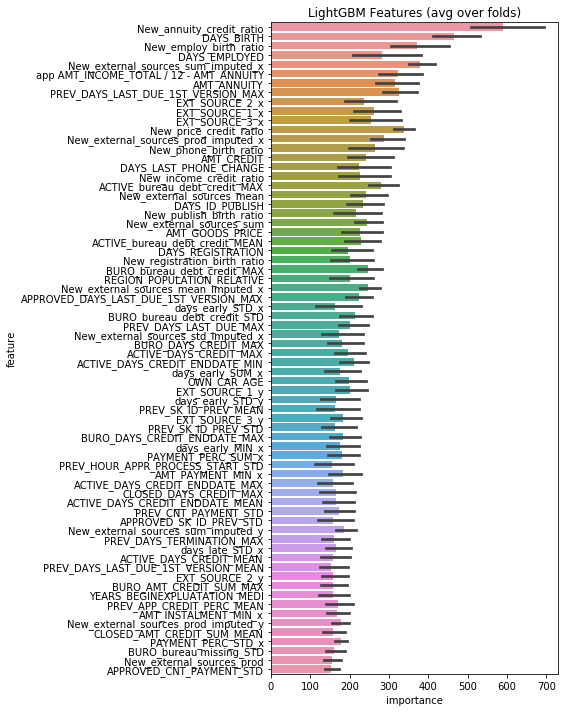

In [15]:
feat_importance = kfold_lightgbm(application_all, num_folds= 5, stratified= False, debug= False)

In [16]:
# Full AUC score 0.791503 with original params
# Full AUC score 0.786129 with simple params
# Full AUC score 0.786026 with simple params and replace the app_train_test
# Full AUC score 0.786129 with simple params and replace the BB
# Full AUC score 0.786532 with simple params and replace the prev_ins_cc_pos
# Full AUC score 0.786516  with simple params and replace the prev_ins_cc_pos and app_train_test (removed the diff section)
# Full AUC score 0.787186  with simple params and replace the prev_ins_cc_pos and app_train_test (removed the diff section and groupbys)
# Full AUC score 0.788018  with simple params and new 1163 features set
# Full AUC score 0.788702  with simple params and new 1163 features set (removed bins)
# Full AUC score 0.789041  with simple params and new 1163 features set (removed bins) and set is_unbalance to true
# Full AUC score 0.793991 with original params and 1163 features set (removed bins) 
# Full AUC score 0.788647  with simple params and new 1742 features set
# Full AUC score 0.788864  with above and inputed ex_source_1
# Full AUC score 0.794007  with above and inputed ex_source_1 and original params (lb 795)
# Full AUC score 0.794961 with above and imputed 1,2,3
# Full AUC score 0.795175 same as above but changed the weighting of month index




## Bayesian Optimization (Performance was not good)

In [21]:
from bayes_opt import BayesianOptimization
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
    params["num_leaves"] = round(num_leaves)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [22]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.5, 1),
                                        'max_depth': (5, 11),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

In [ ]:
lgbBO.maximize(init_points=init_round, n_iter=opt_round)

In [25]:
import lightgbm as lgb

X = application_all[application_all['TARGET'].notnull()].drop('TARGET', axis=1)
y = application_all[application_all['TARGET'].notnull()].TARGET
feats = [f for f in X.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = X[feats]

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.4, 1),
                                            'max_depth': (5, 11),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=1000, learning_rate=0.05)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 


/home/qile/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/qile/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:395: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.784655 + 0.00117293
[400]	cv_agg's auc: 0.79047 + 0.00128325
[600]	cv_agg's auc: 0.792105 + 0.00127287
[800]	cv_agg's auc: 0.792518 + 0.00119315
    1 | 18m21s |    0.79259 |             0.8750 |             0.6167 |      4.8931 |      1.9198 |      5.5228 |            32.7936 |           0.0272 |      35.5251 | 
[200]	cv_agg's auc: 0.782767 + 0.0012973
[400]	cv_agg's auc: 0.789263 + 0.00144331
[600]	cv_agg's auc: 0.791252 + 0.00134147
[800]	cv_agg's auc: 0.792116 + 0.0013678
[1000]	cv_agg's auc: 0.792397 + 0.00145178
    2 | 15m28s |    0.79240 |             0.7173 |             0.4501 |      3.9958 |      0.4301 |      5.1213 |            32.5443 |           0.0776 |      39.0190 | 
[200]	cv_agg's auc: 0.786789 + 0.00152554
[400]	cv_agg's auc: 0.790904 + 0.00148255
[600]	cv_agg's auc: 0.791321 + 0.00177714
    3 | 19m52s |    0.79139 |             0.7408 |             0.8134 |      2.3074 |      2.8340 |      9.9957 |            32.7620 |           0.0462 |     

/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.784444 + 0.00140445
[400]	cv_agg's auc: 0.790353 + 0.00157231
[600]	cv_agg's auc: 0.791525 + 0.0019099
[800]	cv_agg's auc: 0.791778 + 0.00194264
    6 | 15m10s |    0.79182 |             0.9034 |             0.3293 |      4.6291 |      0.1846 |      6.8019 |             5.3059 |           0.0229 |      25.0463 | 
[200]	cv_agg's auc: 0.782229 + 0.00116133
[400]	cv_agg's auc: 0.788964 + 0.00104371
[600]	cv_agg's auc: 0.790866 + 0.00117689
[800]	cv_agg's auc: 0.791618 + 0.00125797
[1000]	cv_agg's auc: 0.791759 + 0.00118269
    7 | 15m10s |    0.79179 |             0.9478 |             0.8130 |      0.1486 |      

/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00040517]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


[200]	cv_agg's auc: 0.783815 + 0.00145621
[400]	cv_agg's auc: 0.789968 + 0.00138158
[600]	cv_agg's auc: 0.791359 + 0.0014347
[800]	cv_agg's auc: 0.791695 + 0.00150461
    9 | 16m40s |    0.79173 |             0.4627 |             0.8467 |      4.9934 |      0.0710 |      6.4318 |            29.3621 |           0.0126 |      25.7646 | 


/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.23074387e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


[200]	cv_agg's auc: 0.784049 + 0.00146126
[400]	cv_agg's auc: 0.790407 + 0.0016461
[600]	cv_agg's auc: 0.791978 + 0.00170177
[800]	cv_agg's auc: 0.792666 + 0.00163804
   10 | 15m16s |    0.79274 |             0.9730 |             0.1183 |      4.6632 |      0.6412 |      5.5162 |            34.6019 |           0.0340 |      25.5645 | 
[200]	cv_agg's auc: 0.782881 + 0.00154619
[400]	cv_agg's auc: 0.789912 + 0.00159019
[600]	cv_agg's auc: 0.792092 + 0.0016787
[800]	cv_agg's auc: 0.792943 + 0.00178845
[1000]	cv_agg's auc: 0.793212 + 0.00166274
   11 | 14m10s |    0.79322 |             0.8229 |             0.1164 |      4.6316 |      2.5986 |      5.4844 |             5.7677 |           0.0677 |      44.2376 | 
[200]	cv_agg's auc: 0.7826 + 0.00107444
[400]	cv_agg's auc: 0.789334 + 0.0012109
[600]	cv_agg's auc: 0.791243 + 0.00125806
[800]	cv_agg's auc: 0.792156 + 0.00133926
[1000]	cv_agg's auc: 0.792446 + 0.00140023
   12 | 13m54s |    0.79253 |             0.8932 |             0.1321 |    

/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00032424]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


[200]	cv_agg's auc: 0.786212 + 0.00156558
[400]	cv_agg's auc: 0.791248 + 0.00169939
[600]	cv_agg's auc: 0.791868 + 0.00188042
   13 | 17m34s |    0.79195 |             0.9749 |             0.1132 |      4.2804 |      0.0269 |     10.9394 |             6.7252 |           0.0992 |      40.6564 | 


/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00031935]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/qile/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.87092766e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[200]	cv_agg's auc: 0.783334 + 0.00140925
[400]	cv_agg's auc: 0.789434 + 0.0013182
[600]	cv_agg's auc: 0.790961 + 0.00135529
[800]	cv_agg's auc: 0.791729 + 0.00153627
[1000]	cv_agg's auc: 0.791963 + 0.00156063
   14 | 12m42s |    0.79196 |             0.6623 |             0.1504 |      0.1124 |      2.4678 |      5.0656 |             5.1487 |           0.0648 |      35.8713 | 
[200]	cv_agg's auc: 0.783284 + 0.00151679
[400]	cv_agg's auc: 0.789704 + 0.00147613
[600]	cv_agg's auc: 0.791711 + 0.00181624
[800]	cv_agg's auc: 0.792534 + 0.00185323
[1000]	cv_agg's auc: 0.7929 + 0.00185862
   15 | 14m06s |    0.79297 |             0.7171 |             0.1599 |      4.5623 |      0.0101 |      5.0307 |             6.1852 |           0.0963 |      44.3128 | 


In [26]:
opt_params

{'num_leaves': 44.23758479961977,
 'feature_fraction': 0.11636305779558508,
 'bagging_fraction': 0.8228599207358916,
 'max_depth': 5.484447720964215,
 'lambda_l1': 4.631584510068076,
 'lambda_l2': 2.598635105918363,
 'min_split_gain': 0.06765021492514638,
 'min_child_weight': 5.767651578232128}

In [40]:
train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)


params = {'num_leaves': 32,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.7,
 #'max_depth': 5,
 #'lambda_l1': 4.631584510068076,
# 'lambda_l2': 2.598635105918363,
# 'min_split_gain': 0.06765021492514638,
 #'min_child_weight': 5.767651578232128,
   'n_estimators':600,
            'learning_rate':0.05,      

'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
         }

    
    
clf = lgb.train(params, train_data,valid_sets=train_data,
                        
                         verbose_eval=100)








/home/qile/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.791201
[200]	training's auc: 0.824703
[300]	training's auc: 0.84768
[400]	training's auc: 0.866097
[500]	training's auc: 0.881599
[600]	training's auc: 0.894973


In [41]:

test_df = application_all[application_all['TARGET'].isnull()]
sub_preds = np.zeros(test_df.shape[0])



sub_preds = clf.predict(test_df[feats])



test_df['TARGET'] = sub_preds
submission_file_name = 'submission/full_simple_params.csv'

test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)

/home/qile/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
